# Global Sensitivity Analysis

## Overview
This notebook explores the sensitivity analysis of the model, seeking to identify the variables that have the highest impact towards our desired outcomes. We aim to understand our model further, ensuring a pinpoint decision-making support for our clients in the Overijssel region.

## Approach
The outcomes of this sensitivity aligns with the mandates of our clients, Dike Rings Gorssel and Deventer, which are death and costs.

Our sensitivity analysis happened early in our cooperation with our clients, which results in limited information being available to them and to us as well. Working around this, our subsequent approach in the sensitivity analysis is we treat our policy levers as uncertainties, so that we have a clear picture of the whole space including the interactions of each parameter.

## Method
Doing the GSA involves using several methods. In this notebook, we use SOBOL and Extra-Trees. The reason we use them both is due to SOBOL's limitation in handling nonlinearity, as several uncertainties as well as our levers are categorical, despite its accuracy. Seeking to understand as much as we can from our variables, we decided to use them both and present them to our clients.

## Code

### Imports

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import os
from ema_workbench import (
    Policy,
    ema_logging,
    MultiprocessingEvaluator,
    save_results,
    load_results,
    Samplers
)



### Loading

In [2]:
from ema_workbench import load_results

# Path to your saved results
file_path = "../experimental data/pf_3_exploratory_runs_levers_as_factors_SobolSampling.tar.gz"

# Load results
experiments, outcomes = load_results(file_path)

print(f"✅ Loaded {len(experiments)} experiments and {len(outcomes)} outcomes from file.")

✅ Loaded 20400 experiments and 12 outcomes from file.


In [3]:
parameter_names = list(experiments.columns)

# Remove special EMA columns (if present)
parameter_names = [p for p in parameter_names if p not in ['policy', 'model']]

problem = {
    'num_vars': len(parameter_names),
    'names': parameter_names,
    'bounds': [[0, 1]] * len(parameter_names)  # Dummy bounds for SALib; not used in analyze
}

N = 200  # The same base N you used when generating the sample
expected_len = N * (len(parameter_names) + 2)


### SOBOL

In [4]:
from SALib.analyze import sobol

sobol_results_mean = {}
sobol_results_std = {}
sobol_results_final = {}

for outcome_name, values in outcomes.items():
    arr = np.asarray(values)[:expected_len]

    if arr.ndim == 1:
        y_mean = arr
        y_std = np.zeros_like(arr)
        y_final = arr
    elif arr.ndim == 2:
        y_mean = arr.mean(axis=1)
        y_std = arr.std(axis=1)
        y_final = arr[:, -1]
    else:
        continue

    sobol_results_mean[outcome_name] = sobol.analyze(problem, y_mean, calc_second_order=False)
    sobol_results_std[outcome_name] = sobol.analyze(problem, y_std, calc_second_order=False)
    sobol_results_final[outcome_name] = sobol.analyze(problem, y_final, calc_second_order=False)

/Users/muhammadhaidar/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/Documents/Kuliah/S2/Q1.4/Model-based Decision Making/Assignments/.venv/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/muhammadhaidar/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/Documents/Kuliah/S2/Q1.4/Model-based Decision Making/Assignments/.venv/lib/python3.11/site-packages/SALib/analyze/sobol.py:141: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract parameter names from the problem
parameter_names = problem['names']

# Convert a Sobol result dictionary into a tidy DataFrame
def sobol_to_dataframe(sobol_dict, parameter_names, label):
    records = []
    for outcome_name, Si in sobol_dict.items():
        for i, param in enumerate(parameter_names):
            records.append({
                'Outcome': outcome_name,
                'Parameter': param,
                'S1': Si['S1'][i],
                'ST': Si['ST'][i],
                'S1_conf': Si['S1_conf'][i],
                'ST_conf': Si['ST_conf'][i],
                'Reduction': label
            })
    return pd.DataFrame(records)

# Convert all three dictionaries to DataFrames


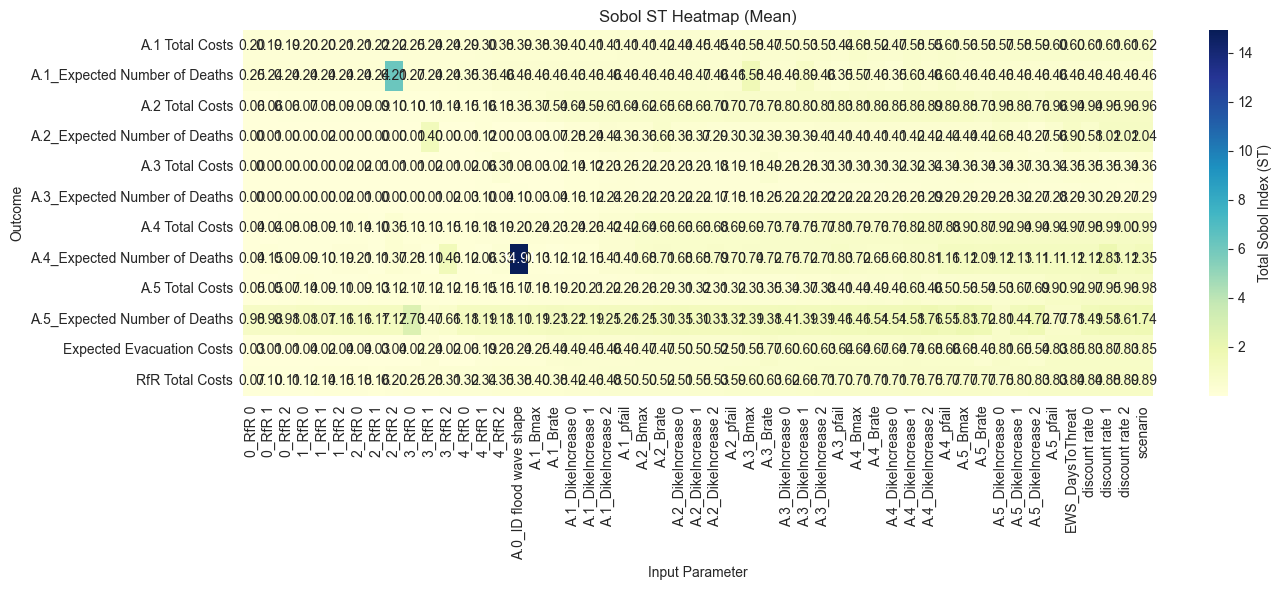

⚠️ No valid data to plot for reduction type: Std


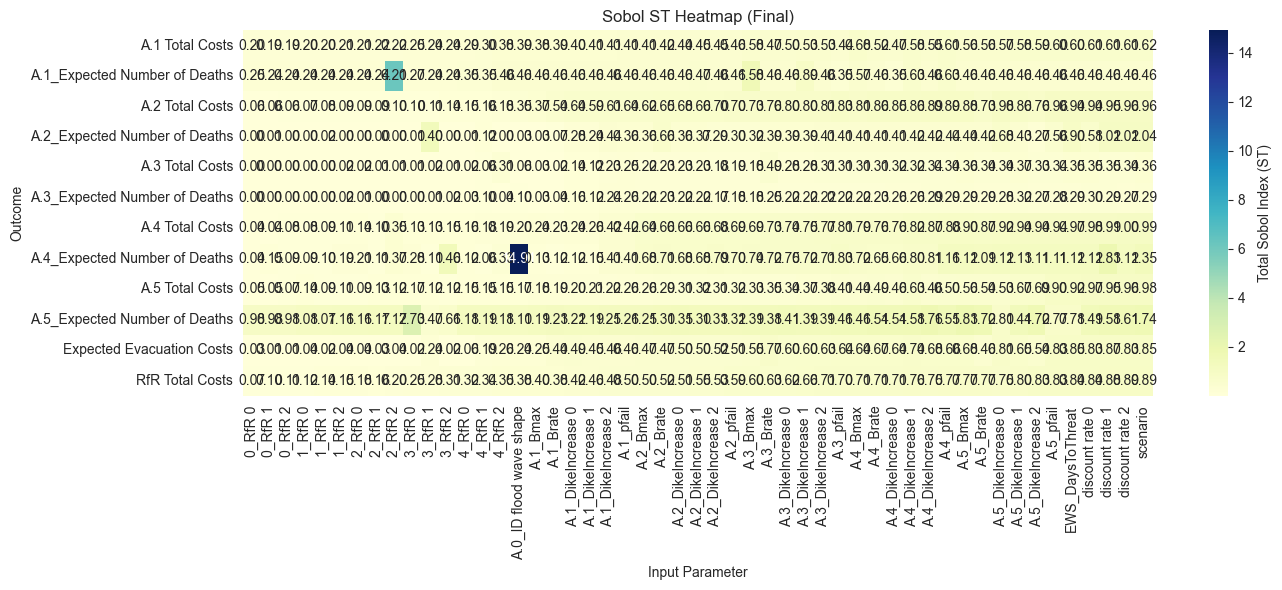

In [6]:
df_mean = sobol_to_dataframe(sobol_results_mean, parameter_names, 'Mean')
df_std = sobol_to_dataframe(sobol_results_std, parameter_names, 'Std')
df_final = sobol_to_dataframe(sobol_results_final, parameter_names, 'Final')

# Combine them all into one long-form DataFrame
df_all = pd.concat([df_mean, df_std, df_final], ignore_index=True)

# Plotting function for heatmaps
def plot_sobol_heatmap(df, reduction_type):
    pivot = df[df['Reduction'] == reduction_type].dropna(subset=["ST"])\
        .pivot(index='Outcome', columns='Parameter', values='ST')

    if pivot.empty:
        print(f"⚠️ No valid data to plot for reduction type: {reduction_type}")
        return

    plt.figure(figsize=(14, max(6, len(pivot) * 0.4)))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap='YlGnBu', cbar_kws={'label': 'Total Sobol Index (ST)'})
    plt.title(f"Sobol ST Heatmap ({reduction_type})")
    plt.ylabel("Outcome")
    plt.xlabel("Input Parameter")
    plt.tight_layout()
    plt.show()

# Plot all three heatmaps
plot_sobol_heatmap(df_all, 'Mean')
plot_sobol_heatmap(df_all, 'Std')
plot_sobol_heatmap(df_all, 'Final')

#### Grouped based on levers or uncertainties

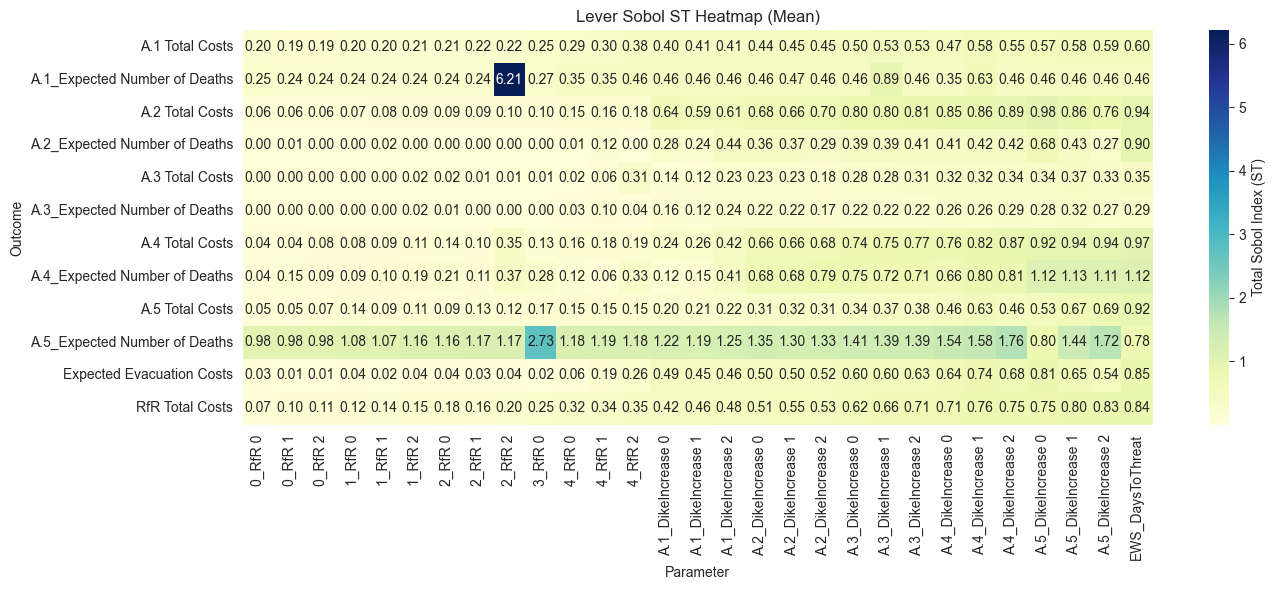

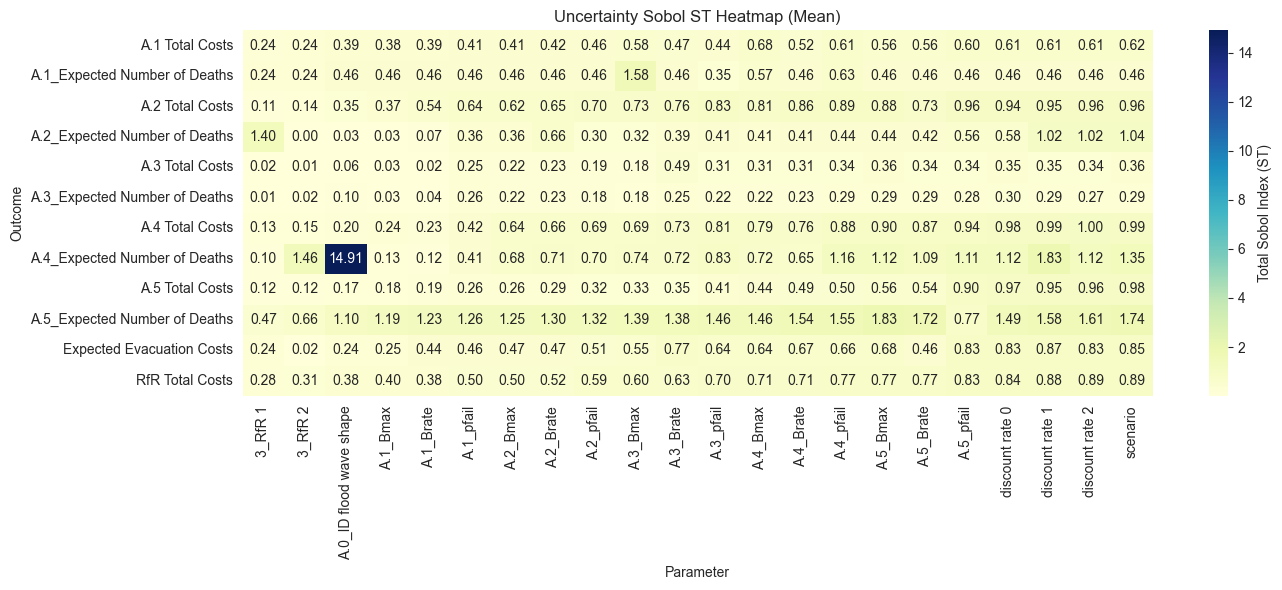

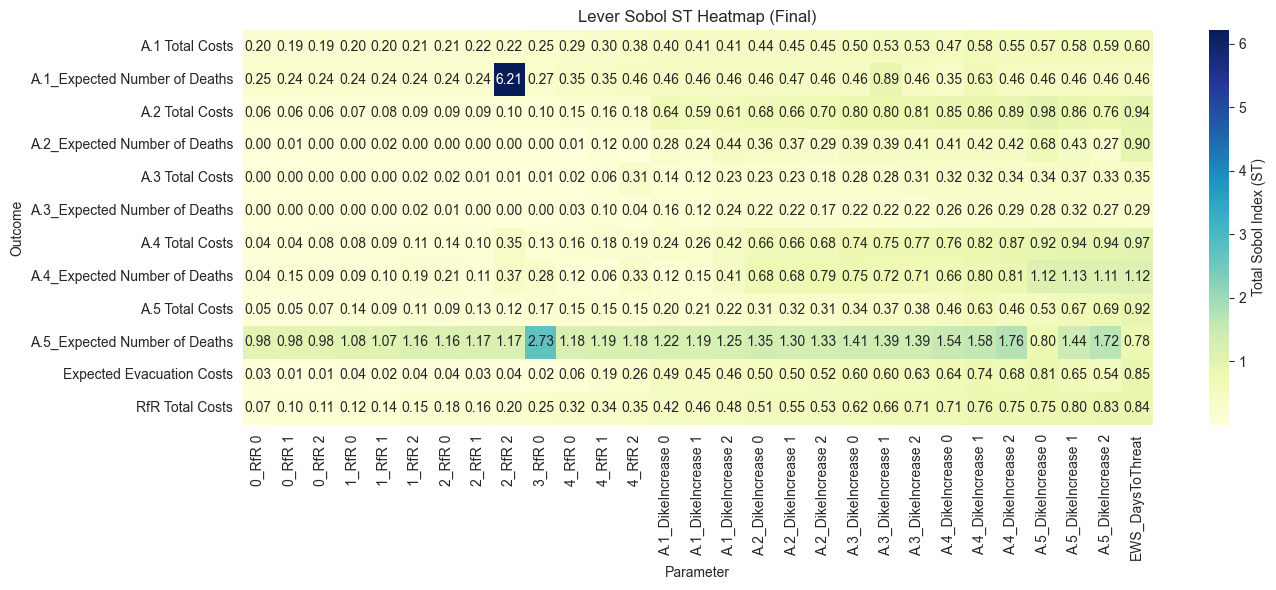

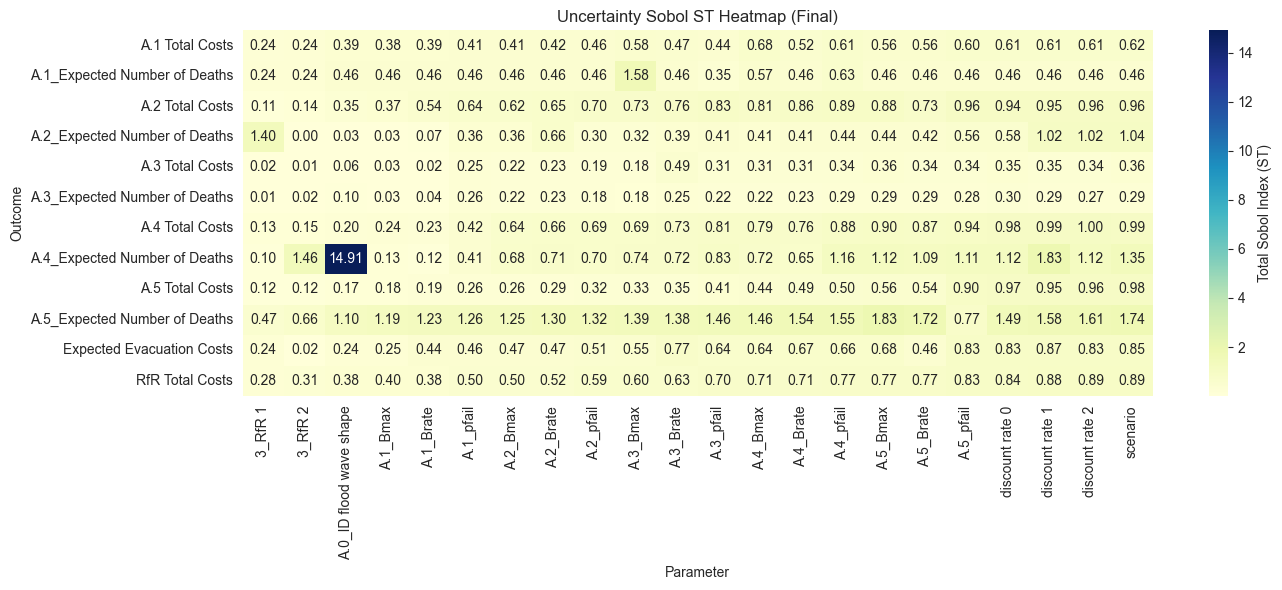

In [9]:
lever_parameters = [
    "A.1_DikeIncrease 0",
    "A.1_DikeIncrease 1",
    "A.1_DikeIncrease 2",
    "A.2_DikeIncrease 0",
    "A.2_DikeIncrease 1",
    "A.2_DikeIncrease 2",
    "A.3_DikeIncrease 0",
    "A.3_DikeIncrease 1",
    "A.3_DikeIncrease 2",
    "A.4_DikeIncrease 0",
    "A.4_DikeIncrease 1",
    "A.4_DikeIncrease 2",
    "A.5_DikeIncrease 0",
    "A.5_DikeIncrease 1",
    "A.5_DikeIncrease 2",
    "0_RfR 0","0_RfR 1","0_RfR 2",
    "1_RfR 0","1_RfR 1","1_RfR 2",
    "2_RfR 0","2_RfR 1","2_RfR 2",
    "3_RfR 0","0_RfR 1","0_RfR 2",
    "4_RfR 0","4_RfR 1","4_RfR 2",
    "EWS_DaysToThreat"
]

def manually_tag_groups(df, lever_list):
    df = df.copy()
    df["Group"] = df["Parameter"].apply(lambda x: "Lever" if x in lever_list else "Uncertainty")
    return df

df_tagged = manually_tag_groups(df_all, lever_parameters)

def plot_grouped_heatmap(df, reduction_type, group='Lever'):
    df_group = df[(df['Reduction'] == reduction_type) & (df['Group'] == group)].dropna(subset=["ST"])
    pivot = df_group.pivot(index='Outcome', columns='Parameter', values='ST')

    if pivot.empty:
        print(f"⚠️ No valid data to plot for {group} ({reduction_type})")
        return

    plt.figure(figsize=(14, max(6, len(pivot) * 0.4)))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap='YlGnBu', cbar_kws={'label': 'Total Sobol Index (ST)'})
    plt.title(f"{group} Sobol ST Heatmap ({reduction_type})")
    plt.ylabel("Outcome")
    plt.xlabel("Parameter")
    plt.tight_layout()
    plt.show()

plot_grouped_heatmap(df_tagged, 'Mean', group='Lever')
plot_grouped_heatmap(df_tagged, 'Mean', group='Uncertainty')

# Optional for 'Final' or 'Std' reductions
plot_grouped_heatmap(df_tagged, 'Final', group='Lever')
plot_grouped_heatmap(df_tagged, 'Final', group='Uncertainty')


### Extra-Trees

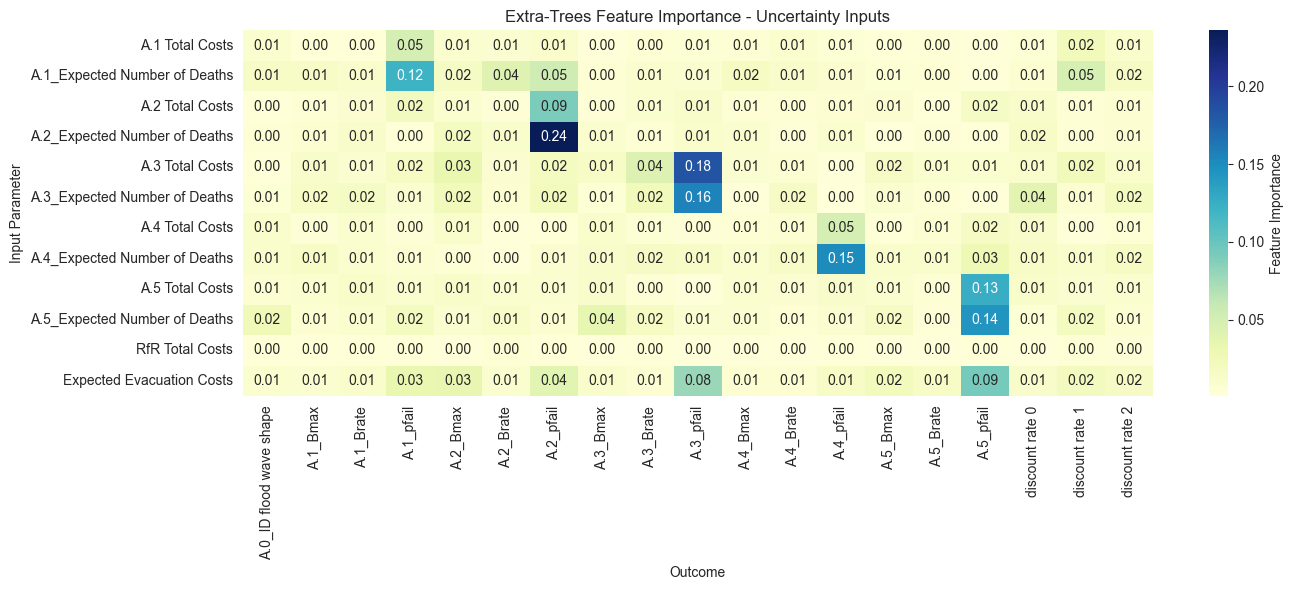

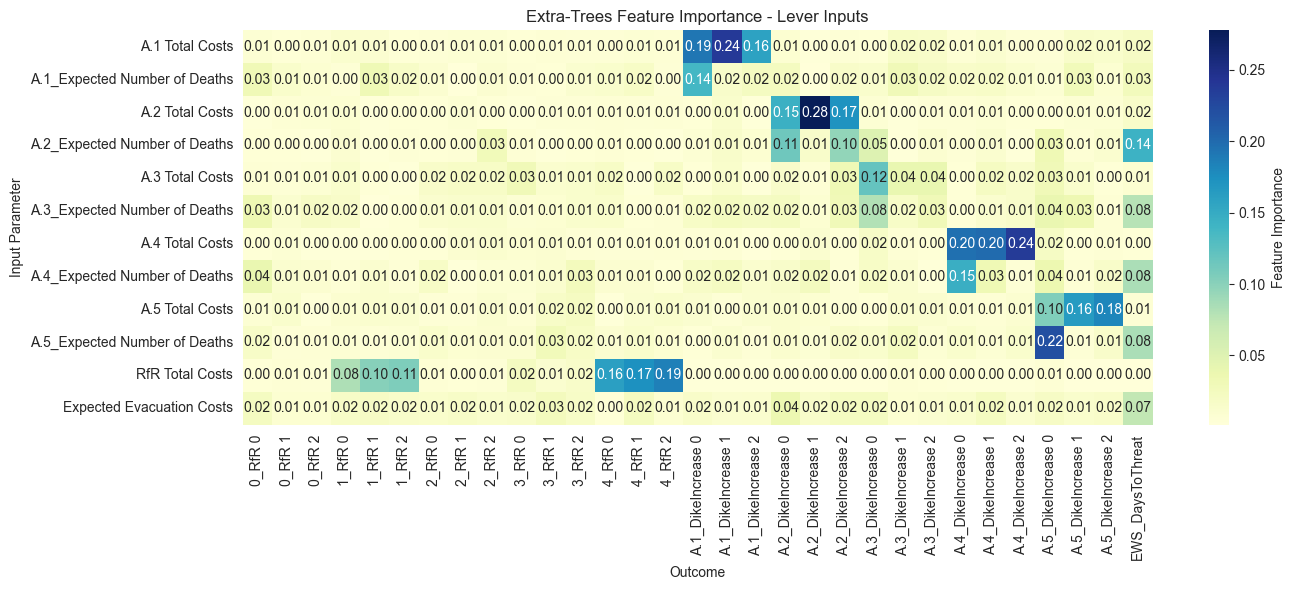

In [8]:
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.feature_scoring import RuleInductionType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Reduce each outcome to a scalar (mean)
y_dict = {}
for name, values in outcomes.items():
    arr = np.asarray(values)
    if arr.ndim == 1:
        y_dict[name] = arr
    elif arr.ndim == 2:
        y_dict[name] = arr.mean(axis=1)
    else:
        print(f"Skipping unsupported shape: {name}, shape={arr.shape}")

# Step 2: Run Extra-Trees scoring
scores_df = feature_scoring.get_feature_scores_all(
    x=experiments,
    y=y_dict,
    alg='extra trees',
    mode=RuleInductionType.REGRESSION,
    nr_trees=100,
    max_features=0.6,
    random_state=123
)

# Step 3: Manually define lever parameters
lever_parameters = [
    "A.1_DikeIncrease 0",
    "A.1_DikeIncrease 1",
    "A.1_DikeIncrease 2",
    "A.2_DikeIncrease 0",
    "A.2_DikeIncrease 1",
    "A.2_DikeIncrease 2",
    "A.3_DikeIncrease 0",
    "A.3_DikeIncrease 1",
    "A.3_DikeIncrease 2",
    "A.4_DikeIncrease 0",
    "A.4_DikeIncrease 1",
    "A.4_DikeIncrease 2",
    "A.5_DikeIncrease 0",
    "A.5_DikeIncrease 1",
    "A.5_DikeIncrease 2",
    "0_RfR 0","0_RfR 1","0_RfR 2",
    "1_RfR 0","1_RfR 1","1_RfR 2",
    "2_RfR 0","2_RfR 1","2_RfR 2",
    "3_RfR 0","3_RfR 1","3_RfR 2",
    "4_RfR 0","4_RfR 1","4_RfR 2",
    "EWS_DaysToThreat"
]

# Step 4: Tag each parameter as 'Lever' or 'Uncertainty'
def manually_tag_groups(df, lever_list):
    df = df.copy()
    df["Group"] = df.index.to_series().apply(lambda x: "Lever" if x in lever_list else "Uncertainty")
    return df

tagged_scores_df = manually_tag_groups(scores_df, lever_parameters)

def plot_extratrees_heatmap(score_df, group='Lever'):
    # Filter only relevant rows
    df_group = score_df[score_df["Group"] == group]

    # Drop non-numeric columns before plotting
    data_only = df_group.drop(columns=["Group"])

    # Make sure the matrix is Outcome x Parameter (transpose if needed)
    pivot = data_only.T

    # Sanity check: remove any non-numeric rows like strings (in case Group wasn't dropped)
    pivot = pivot.apply(pd.to_numeric, errors='coerce')

    plt.figure(figsize=(14, max(6, len(pivot) * 0.4)))
    sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Feature Importance'})
    plt.title(f"Extra-Trees Feature Importance - {group} Inputs")
    plt.xlabel("Outcome")
    plt.ylabel("Input Parameter")
    plt.tight_layout()
    plt.show()


# STEP 6: Run for both groups
plot_extratrees_heatmap(tagged_scores_df, group='Uncertainty')
plot_extratrees_heatmap(tagged_scores_df, group='Lever')
